# Testing Model on New Data
This notebook will walk you through how to load new test dataset to test on the model. Here is the step by step guide:
1. make sure you have these list of files in your local machine:
    - `data_loader_cache.py` in the same directory as this notebook, which has all the functions from optimised_engine_pipeline_MASTER.ipynb
    - `saved_model.pb` file from [echo_model_24.zip](https://deakin365.sharepoint.com/:u:/s/DataBytes2/EUfVgEfT-oNLsr1xpgn3s-YBXlbVI5TafaZctEBB2zheEA?e=jfOjt8)
    - either the original training data from the Google Cloud Bucket or the `class_names_labels.json`, you can pick one that is easiest.
    - the new testing dataset saved in a folder
2. Run the **Initialization** section for installing packages and setting up system constant. Update the system constant for the locations of each files before you run the chunk.
3. for **Loading the New Dataset**, If you have the original training dataset that was used for training the model, specifically b3, run the **Define Species List** section. If you have the `class_names_labels.json` file, run **Load Class Name** section.
4. Run all code chunk for **Convert New Test Data to Mel-Spec** make sure it shows the mel spectrogram results correctly
5. Run all code chunk in **Load the Saved Model & Test** to get the predicted output

## Initialization
This chunk will import all the necessary packages. The details about the version of each packages is listed below.

    Python Version           :  3.10.12
    TensorFlow Version       :  2.17.0
    Librosa Version          :  0.10.2.post1
    Audiomentations Version  :  0.37.0

In [1]:
from platform import python_version
import tensorflow as tf
import librosa as lb
import audiomentations as augs
import diskcache as dc
import functools
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from collections import defaultdict
import json



import warnings
warnings.filterwarnings("ignore") #ignore warnings

import data_loader_cache as dlc # data loading & processing functions from optimised_engine_pipeline_MASTER

# print system information
print('Python Version           : ', python_version())
print('TensorFlow Version       : ', tf.__version__)
print('Librosa Version          : ', lb.__version__)
print('Audiomentations Version  : ', augs.__version__)


Python Version           :  3.10.12
TensorFlow Version       :  2.17.0
Librosa Version          :  0.10.2.post1
Audiomentations Version  :  0.37.0


### Defining the File Locations in System Constants (SC)

Here are the details about each file:
1. `AUDIO_DATA_DIRECTORY` this is **OPTIONAL**. retrieved from Google Cloud Bucket, see instructions on [data README file](https://github.com/DataBytes-Organisation/Project-Echo/tree/main/src/Prototypes/data) we are using the b3 folder. 
2. `CACHE_DIRECTORY` create a new empty folder and name it cache, paste the location here
3. `MODEL_DIRECTORY` model is retrieved from the zip file shared in the teams channel [echo_model_24.zip](https://deakin365.sharepoint.com/:u:/s/DataBytes2/EUfVgEfT-oNLsr1xpgn3s-YBXlbVI5TafaZctEBB2zheEA?e=jfOjt8) Make sure the path pasted here is the path to the folder that contains saved_model.pb (do not include `saved_model.pb` in the path).
4. `CLASS_NAMES_DIRECTORY` the path that leads to `class_names_labels.json` file. Can be retrieved from GitHub under tutorial folder
5. `NEW_DATA_DIRECTORY` the path that leads to the new dataset that you want to test. Make sure the directory is set similarly to the training dataset:

    >   `path-to-your-new-dataset/dataset/`
     >>     Name of Species 1/
     >>>     audio_file1.mp3 (or '.ogg', '.mp3', '.wav', '.flac')
     >>>     audio_file2.mp3
     >>>     audio_file3.mp3
     >>     Name of Species 2/
     >>>     audio_file4.mp3
     >>>     audio_file5.mp3
     >>     ...etc

If name of species is unknown, just save it as numbers

In [12]:
SC = {
    'AUDIO_DATA_DIRECTORY': "C:/Users/regin/Documents/SIT374/train_data/b3", #original dataset location. Not needed if using JSON file
    'CACHE_DIRETORY': "C:/Users/regin/Documents/SIT374/new_test/cache", #create a new folder for cache
    'MODEL_DIRECTORY': "C:/Users/regin/Documents/SIT374/Project-Echo/src/Components/Engine/models/echo_model/1/", #directory of the saved_model.pb file
    'CLASS_NAMES_DIRECTORY': "class_names_labels.json", #class names and labels JSON file
    'NEW_DATA_DIRECTORY': "C:/Users/regin/Documents/SIT374/new_test/dataset", #new test dataset


    'USE_DISK_CACHE': True,
    'CLASSIFIER_BATCH_SIZE': 16
}

## Loading the New Dataset
We will be using the functions from optimised_engine_pipeline_MASTER as refrence on how to convert the data to mel spectrograms.


In [5]:
# Using the Disk Cache and enforcing memory limt.
if SC['USE_DISK_CACHE']:
    cache = dc.Cache(SC['CACHE_DIRETORY'], cull_limit=0, size_limit=10**9) 
# enforce max 5GB memory on GPU for this notebook if you have a small GPU
dlc.enforce_memory_limit(5120)

### Define the Species List
Get the list of species names from the original dataset. Ignore this section if you do not have the original dataset downloaded. Instead, jump to 'Load Class Names' section

In [6]:
def species_list(directory):
    """
    Walk through the directory and gather file paths and labels.
    """
    labels = []
    class_names = sorted([dir.name for dir in Path(directory).glob('*') if dir.is_dir()])
    

    for label, class_name in enumerate(class_names):
        class_dir = Path(directory) / class_name
        for file_path in class_dir.glob(f'**/*'):
            labels.append(label)  # Store the integer label instead of the class name

    return labels, class_names

In [7]:
labels, class_names = species_list(SC['AUDIO_DATA_DIRECTORY'])

print(f" labels: {labels}")
print(f"class_names: {class_names}")
print(f"Number of classes: {len(class_names)}")

 labels: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

Save the variables labels and class_names as JSON file

In [6]:
# Save class_names and labels to a JSON file
data = {
    "class_names": class_names,
    "labels": labels
}

with open('class_names_labels.json', 'w') as f:
    json.dump(data, f)

### Load Class Name
This section assume that you have 'class_names_labels.json' file in your directory.

In [8]:
# Load class_names and labels from the JSON file
with open(SC['CLASS_NAMES_DIRECTORY'], 'r') as f:
    data = json.load(f)

class_names = data['class_names']
labels = data['labels']


### Convert New Test Data to Mel-Spec

In [9]:
def paths_and_labels_to_dataset(audio_paths, labels, num_classes):
    """
    Create a dataset from file paths and corresponding labels.
    """
    # Convert labels to one-hot encoded format using tf.one_hot
    one_hot_labels = tf.one_hot(labels, depth=num_classes)

    # Create TensorFlow datasets for the paths and labels
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    label_ds = tf.data.Dataset.from_tensor_slices(one_hot_labels)

    # Zip both datasets into a single dataset
    zipped_path_ds = tf.data.Dataset.zip((path_ds, label_ds))
    
    return zipped_path_ds


def audio_files(directory, file_types=('.ogg', '.mp3', '.wav', '.flac')):
    """
    Walk through the directory and gather file paths and labels.
    """
    audio_files = []
    labels = []
    class_names = sorted([dir.name for dir in Path(directory).glob('*') if dir.is_dir()])
    

    for label, class_name in enumerate(class_names):
        class_dir = Path(directory) / class_name
        for file_path in class_dir.glob(f'**/*'):
            if file_path.suffix in file_types:
                audio_files.append(str(file_path))
                labels.append(label)  # Store the integer label instead of the class name

    return audio_files, labels


In [10]:
def create_datasets(audio_dir, class_names):
    """
    Create train, validation, and test datasets from audio directory.
    """
    # Index the directory and get file paths and labels
    file_paths, labels = audio_files(audio_dir)

    # Convert paths and labels to a TensorFlow dataset
    dataset = paths_and_labels_to_dataset(
        audio_paths=file_paths,
        labels=labels,
        num_classes=len(class_names)
    )
    
    # Calculate the size of the dataset
    dataset_size = len(file_paths)
    

    # Split the dataset
    dataset = dataset.take(dataset_size)

    return dataset

test_ds = create_datasets(SC['NEW_DATA_DIRECTORY'], class_names)

print(f"Number of test samples: {len(test_ds)}")
print(f"print labels from test_ds {test_ds}")

Number of test samples: 5
print labels from test_ds <_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(118,), dtype=tf.float32, name=None))>


In [13]:

parallel_calls = tf.data.AUTOTUNE
cache_output_types = (tf.string,tf.float32,tf.int32,tf.string,tf.int32)
procs_output_types = (tf.float32,tf.float32,tf.int32,tf.string,tf.int32)



test_dataset = (test_ds
                .map(dlc.tensorflow_add_variant_and_cache, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_start, cache_output_types), num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_load_and_decode_file, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_load_random_subsection, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_dataset_melspectro_pipeline, procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_reshape_image_pipeline, num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                .map(functools.partial(dlc.python_fuction_wrapper, dlc.python_disk_cache_end, dlc.procs_output_types), num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_output_shape_setter, num_parallel_calls=parallel_calls)
                .map(dlc.tensorflow_drop_variant_and_cache, num_parallel_calls=parallel_calls)
                .batch(SC['CLASSIFIER_BATCH_SIZE'])
                .prefetch(parallel_calls)
                .repeat(count=1)

)

 sample info: (5, 260, 260, 3), 
 label info: (5, 118) 
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

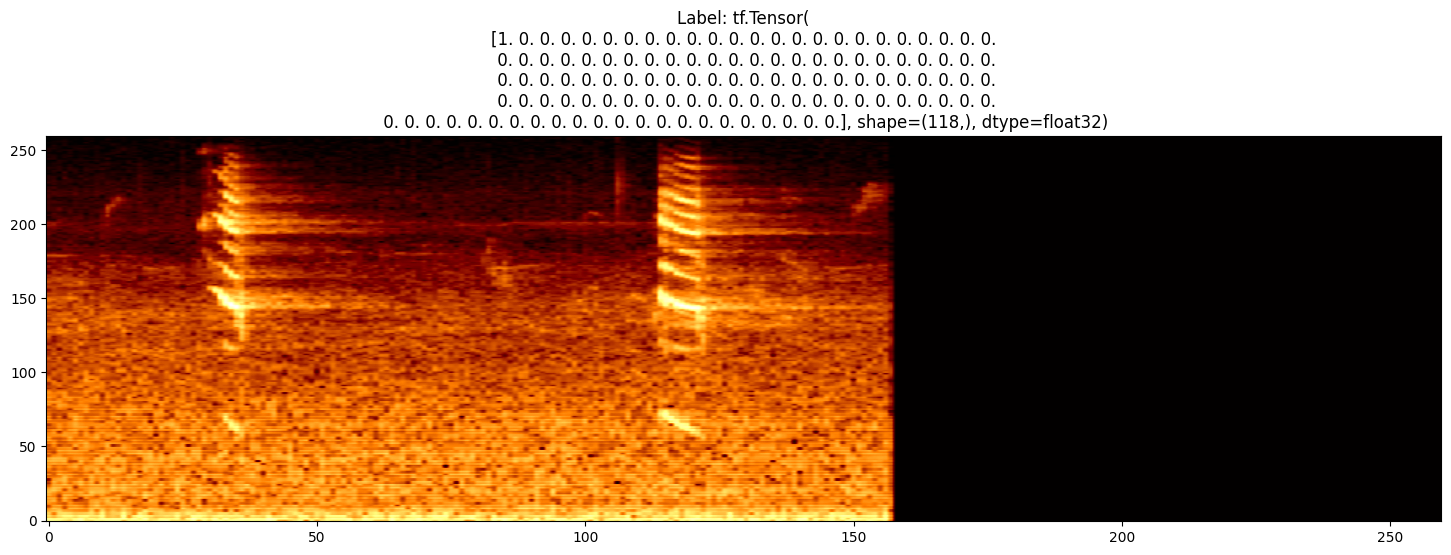

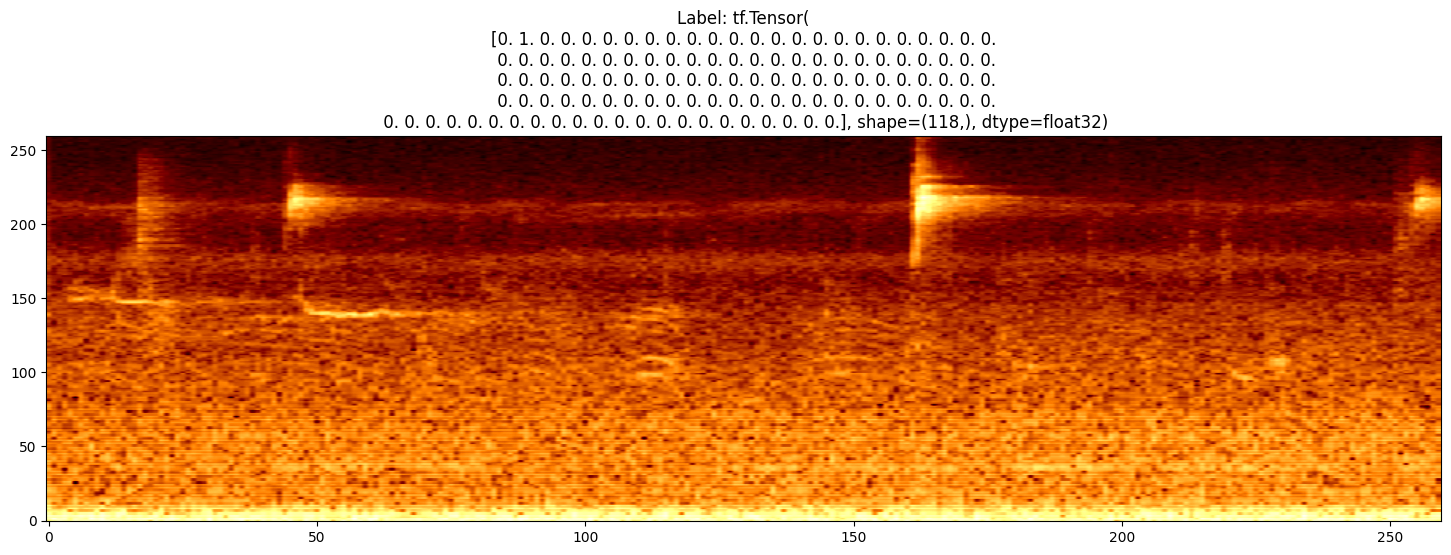

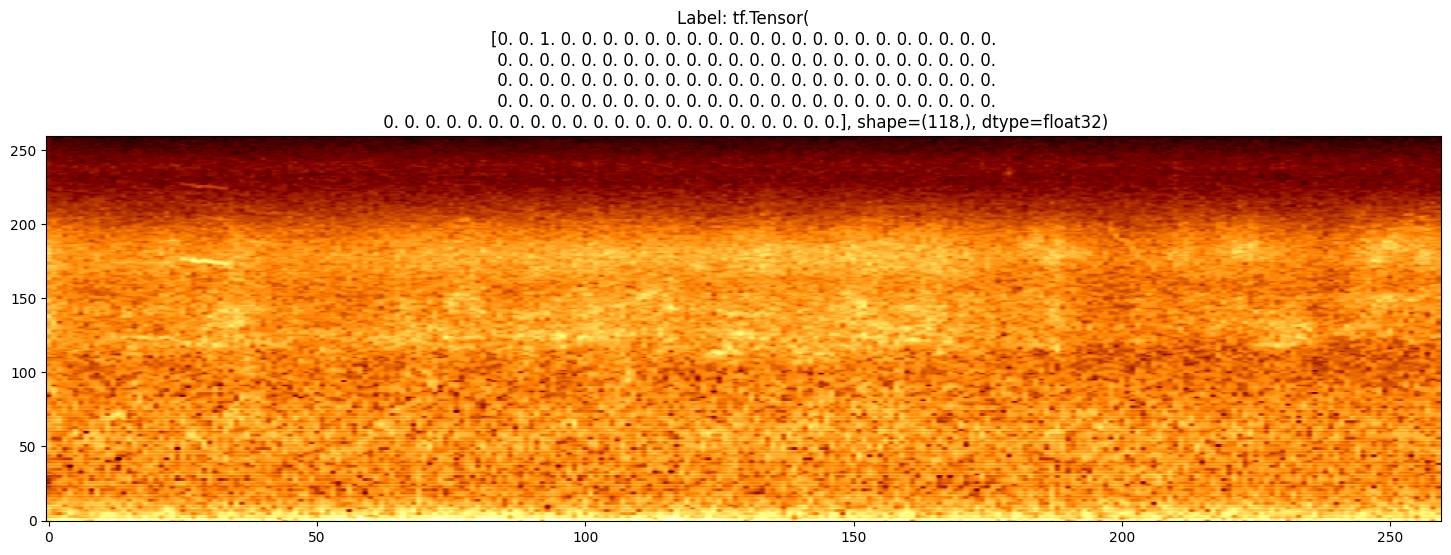

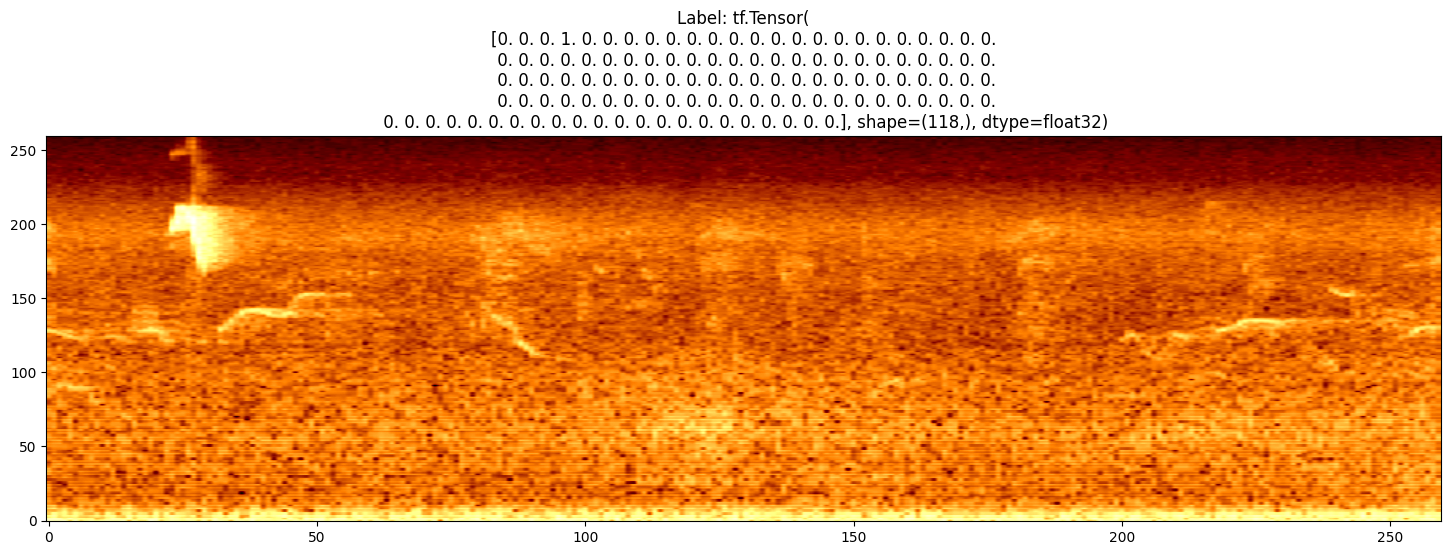

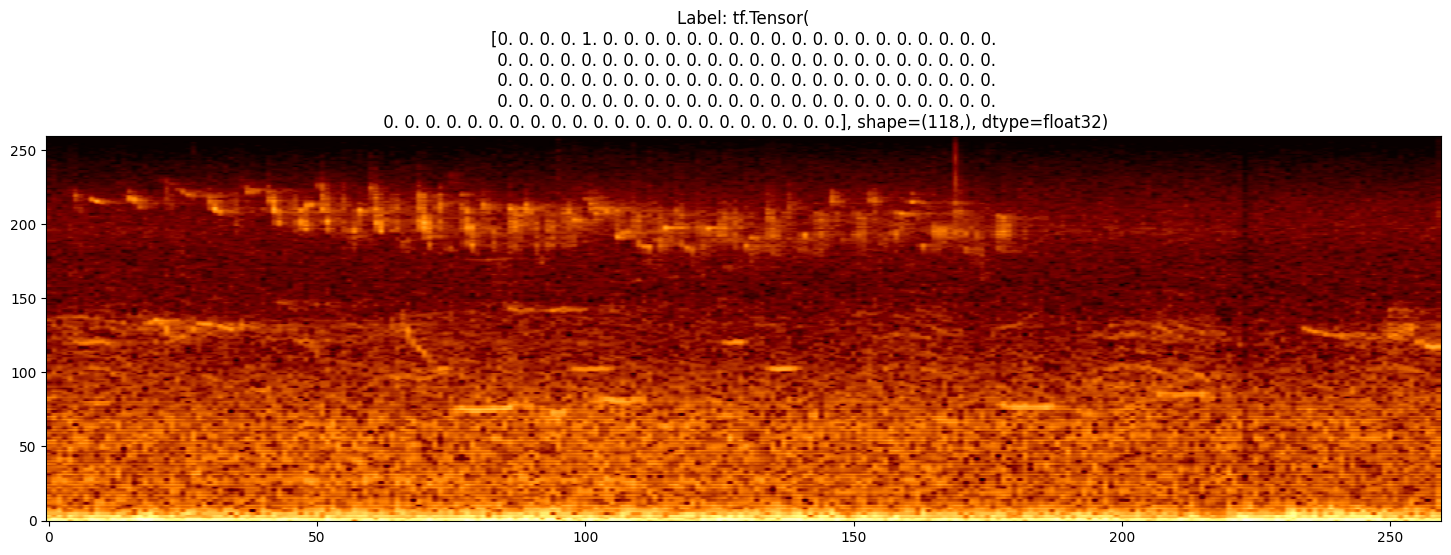

In [14]:
for melspectrogram,label in test_dataset.take(1):
    print(f' sample info: {melspectrogram.shape}, \n label info: {label.shape} \n {label}')
    for example in range(melspectrogram.shape[0]):
        plt.figure(figsize=(18,5))
        plt.imshow(melspectrogram[example,:,:,0].numpy().T, cmap='afmhot', origin='lower', aspect='auto')
        plt.title('Label: ' + str(label[example,:]))
        plt.show()

## Load the Saved Model & Test
Load save model from 'src/Components/Engine/models/echo_model/1/' using TFSM Layers

In [15]:
# Load the saved model
model_inference_layer = tf.keras.layers.TFSMLayer(SC['MODEL_DIRECTORY'], call_endpoint='serving_default')

In [13]:
model_no = tf.keras.Sequential([
    model_inference_layer
])

### Test the Loaded Model on New Data

In [14]:
# Function to predict class and probability given a prediction
def predict_class(predictions):
    # Get the index of the class with the highest predicted probability
    predicted_index = int(tf.argmax(tf.squeeze(predictions)).numpy())
    # Get the class name using the predicted index
    predicted_class = class_names[predicted_index]
    # Calculate the predicted probability for the selected class
    predicted_probability = 100.0 * tf.nn.softmax(predictions)[predicted_index].numpy()
    # Round the probability to 2 decimal places
    predicted_probability = str(round(predicted_probability, 2))
    return predicted_class, predicted_probability

# Initialize dictionaries to track correct and total predictions per class
correct_predictions = defaultdict(int)
total_predictions = defaultdict(int)

# Display class names and run prediction on test entries
print(f'Class names: {class_names}')
for features, labels in test_dataset:
    # Generate predictions for the given features
    predictions_dict = model_no(features, training=False)  # TFSMLayer returns a dict
    predictions = predictions_dict['dense'].numpy()  # Extract the actual predictions from the dict

    # Iterate over each item in the batch
    for batch_idx in range(predictions.shape[0]):
        # # Get the index of the true class
        # true_index = int(tf.argmax(tf.squeeze(labels[batch_idx])).numpy())
        # # Get the true class name using the true index
        # true_class = class_names[true_index]

        # Predict class and probability using the prediction function
        predicted_class, predicted_probability = predict_class(predictions[batch_idx])

        # print(f'True class      : {true_class}')
        print(f'Predicted class : {predicted_class}')
        print(f'Predicted probability : {predicted_probability}')

Class names: ['Acanthiza chrysorrhoa', 'Acanthiza lineata', 'Acanthiza nana', 'Acanthiza pusilla', 'Acanthiza reguloides', 'Acanthiza uropygialis', 'Acanthorhynchus tenuirostris', 'Accipiter cirrocephalus', 'Aidemosyne modesta', 'Alauda arvensis', 'Anhinga novaehollandiae', 'Anthochaera phrygia', 'Antigone rubicunda', 'Artamus cinereus', 'Artamus cyanopterus', 'Artamus minor', 'Artamus superciliosus', 'Barnardius zonarius', 'Callocephalon fimbriatum', 'Calyptorhynchus banksii', 'Calyptorhynchus lathami', 'Capra Hircus', 'Carduelis carduelis', 'Carterornis leucotis', 'Cervus Unicolour', 'Ceyx azureus', 'Chenonetta jubata', 'Chlamydera nuchalis', 'Cincloramphus mathewsi', 'Cinclosoma punctatum', 'Cisticola exilis', 'Climacteris picumnus', 'Colluricincla harmonica', 'Conopophila albogularis', 'Cophixalus exiguus', 'Cophixalus infacetus', 'Cophixalus ornatus', 'Coracina novaehollandiae', 'Coracina papuensis', 'Corcorax melanorhamphos', 'Cormobates leucophaea', 'Corvus mellori', 'Coturnix p

### Check the Dictionary

In [ ]:
for features, labels in test_dataset:
    # # Generate predictions for the given features
    # predictions_dict = model_no.predict(features)
    
    # Check if the output is a dictionary
    if isinstance(predictions_dict, dict):
        # Print the keys in the predictions dictionary
        print(f'Keys in the predictions dictionary: {predictions_dict.keys()}')
    else:
        print('The model does not return a dictionary. It returns:', type(predictions_dict))
        break  # Exit after printing for one batch


Keys in the predictions dictionary: dict_keys(['dense'])
